In [10]:

import numpy as np
from glob import glob
import pandas as pd

KINEMATIC_PATH = 'data/**/kine/*csv'
FORCE_PATH = 'data/**/force/*csv'

KINEMATIC_DIR = [i.replace('\\','/') for i in glob(KINEMATIC_PATH)]
FORCE_DIR = [i.replace('\\','/') for i in glob(FORCE_PATH)]

kdf = pd.DataFrame()
fdf = pd.DataFrame()

kdf = pd.DataFrame()
fdf = pd.DataFrame()

for kine_dir, force_dir in zip(KINEMATIC_DIR, FORCE_DIR):
    kine = pd.read_csv(kine_dir)
    force = pd.read_csv(force_dir)
    
    _, kday, _, kfname = kine_dir.split('/')
    _, fday, _, ffname = force_dir.split('/')
    kfname = kfname.replace('.csv','')
    kplayer_name, ktrial, _, _, _, _, kball, _ = kfname.split('_')
    
    ffname = ffname.replace('.csv','')
    fplayer_name, ftrial, _, _, _, _, fball, _ = ffname.split('_')
    
    
    kine['player'] = kplayer_name
    kine['day'] = kday
    kine['trial'] = ktrial
    kine['ball_speed'] = kball
    
    force['player'] = fplayer_name
    force['day'] = fday
    force['trial'] = ftrial
    force['ball_speed'] = fball
    
    kdf = pd.concat([kdf, kine])
    fdf = pd.concat([fdf, force])
    
# 스트림릿 사이드바 설정
selected_name = 'JeremiahLo'; selected_date = '20240323'; selected_trial = '0014'

kine_filtered = kdf[(kdf['player'] == selected_name) & 
                    (kdf['day'] == selected_date) &
                    (kdf['trial'] == selected_trial)]

force_filtered = fdf[(fdf['player'] == selected_name) & 
                    (fdf['day'] == selected_date) &
                    (fdf['trial'] == selected_trial)]

kine_filtered.reset_index(inplace=True, drop=True)
force_filtered.reset_index(inplace=True, drop=True)

k_sr = 180
k_kh_time  = kine_filtered['kh_time'][0]
k_kh_time1 = kine_filtered['kh_time'][0] - k_kh_time
k_fc_time  = kine_filtered['fc_time'][0] - k_kh_time
k_mer_time = kine_filtered['mer_time'][0] - k_kh_time
k_br_time  = kine_filtered['br_time'][0] - k_kh_time
stride_length = round(kine_filtered['stride_length'][0])
ball_speed = round(float(kine_filtered['ball_speed'][0]) * 1.6)

f_sr = 1080
f_kh_time  = force_filtered['kh_time'][0] 
f_kh_time1 = force_filtered['kh_time'][0]  - f_kh_time
f_fc_time  = force_filtered['fc_time'][0]  - f_kh_time
f_mer_time = force_filtered['mer_time'][0] - f_kh_time
f_br_time  = force_filtered['br_time'][0]  - f_kh_time

k_df = kine_filtered.iloc[k_kh_time:int(k_br_time + k_kh_time + (k_sr * 0.2)),:].reset_index(drop=True)
f_df = force_filtered.iloc[f_kh_time:int(f_br_time + f_kh_time + (f_sr * 0.2)),:].reset_index(drop=True)

f_lead_peak_z_time = f_df['lead_peak_z'][0] - f_kh_time
f_rear_peak_z_time = np.where(f_df['REAR_FORCE_Z'] == f_df['REAR_FORCE_Z'].max())[0][0]
force_peak_time = round((f_lead_peak_z_time - f_rear_peak_z_time) / 1080 , 4)

f_rear_peak_y_time = np.where(f_df['REAR_FORCE_Y'] == f_df['REAR_FORCE_Y'].max())[0][0]
f_lead_min_y_time  = f_df['lead_valley_y'][0] - f_kh_time

k_df.drop(['kh_time','fc_time','mer_time','br_time','mir_time'], axis=1, inplace=True)
f_df.drop(['kh_time','fc_time','mer_time','br_time','mir_time'], axis=1, inplace=True)

k_time = k_df['TIME']

f_time = f_df['TIME']
ks_cols = {
    'PELVIS_ANGLUAR_VELOCITY_Z'        : ['PELVIS'   , 'red'],
    'TORSO_ANGLUAR_VELOCITY_Z'         : ['TORSO'    , 'green'],
    'LEAD_ELBOW_ANGULAR_VELOCITY_X'    : ['ELBOW'    , 'blue'],
    'LEAD_SHOULDER_ANGULAR_VELOCITY_Z' : ['SHOULDER' , 'yellow'],
}

In [12]:
force['REAR_MOMENTUM_Y']

0      -0.089037
1      -0.089827
2      -0.090505
3      -0.090981
4      -0.091213
          ...   
1374   -0.204771
1375   -0.205038
1376   -0.205249
1377   -0.205415
1378   -0.205558
Name: HAND_ELBOW_HEIGHT, Length: 1379, dtype: float64

In [6]:
import plotly.graph_objs as go
def kinematic_sequence_plotly(data, ks_cols, time, k_kh_time, k_fc_time, k_mer_time, k_br_time):
    ks = {
        'peak' : {},
        'time' : {},
    }
    
    # Create traces for each data series
    traces = []
    for col in ks_cols:
        trace = go.Scatter(
            x=time, 
            y=data[col], 
            mode='lines', 
            name=ks_cols[col][0],
            line=dict(color=ks_cols[col][-1])
        )
        traces.append(trace)
        ks['peak'][col] = round(data[col].max(), 2)
        ks['time'][col] = np.where(data[col] == data[col].max())[0][0]
    
    event_times = [k_kh_time, k_fc_time, k_mer_time, k_br_time]
    event_names = ['KH', 'FC', 'MER', 'BR']
    shapes = [
        {
            'type': 'line',
            'xref': 'x',
            'yref': 'paper',
            'x0': time[event_time],
            'y0': 0,
            'x1': time[event_time],
            'y1': 1,
            'line': {
                'color': 'black',
                'width': 2,
                'dash': 'dash',
            }
        } for event_time in event_times
    ]
    annotations = [
        {
            'x': time[event_time + 1],
            'y': 0.95,
            'xref': 'x',
            'yref': 'paper',
            'text': label,
            'showarrow': False,
            'font': {
                'color': 'white'
            },
            'textangle': -90
        } for event_time, label in zip(event_times, event_names)
    ]

    # Define the layout with annotations and shapes
    layout = go.Layout(
        title='KINEMATIC SEQUENCE',
        xaxis=dict(title='Time [s]',
                   showgrid=False),
        yaxis=dict(title='Angular Velocity [Deg/s]', 
                   autorange=True,           
                    rangemode='tozero',
                    showgrid=True,         # This will show the horizontal gridlines
                    gridcolor='lightgrey',
                    gridwidth=1,
                    zeroline=False,),
        annotations=annotations,
        shapes=shapes,
        showlegend=True,
        legend=dict(orientation='h'),
        margin=dict(l=40, r=40, t=40, b=40),
        plot_bgcolor='rgb(43,48,61)'
    )

    # Create the figure and add traces to it
    fig = go.Figure(data=traces, layout=layout)
    
    return ks, fig
def transform_list(nums):
    indexed_nums = list(enumerate(nums))
    indexed_nums.sort(key=lambda x: x[1])
    transformed = [0] * len(nums)
    current_rank = 1
    for i in range(len(nums)):
        if i > 0 and indexed_nums[i][1] != indexed_nums[i-1][1]:
            current_rank += 1
        transformed[indexed_nums[i][0]] = current_rank
    return transformed

kinematic_values, kinematic_fig = kinematic_sequence_plotly(k_df, ks_cols, k_time, k_kh_time1, k_fc_time, k_mer_time, k_br_time)

peak_pel = round(kinematic_values['peak']['PELVIS_ANGLUAR_VELOCITY_Z']); time_pel = kinematic_values['time']['PELVIS_ANGLUAR_VELOCITY_Z']
peak_tor = round(kinematic_values['peak']['TORSO_ANGLUAR_VELOCITY_Z']);time_tor = kinematic_values['time']['TORSO_ANGLUAR_VELOCITY_Z']
peak_elb = round(kinematic_values['peak']['LEAD_ELBOW_ANGULAR_VELOCITY_X']);time_elb = kinematic_values['time']['LEAD_ELBOW_ANGULAR_VELOCITY_X']
peak_sho = round(kinematic_values['peak']['LEAD_SHOULDER_ANGULAR_VELOCITY_Z']);time_sho = kinematic_values['time']['LEAD_SHOULDER_ANGULAR_VELOCITY_Z']

total_time = k_br_time+1 - k_fc_time

pel_time = round(100 * (time_pel+1 - k_fc_time) / total_time)
tor_time = round(100 * (time_tor+1 - k_fc_time) / total_time)
elb_time = round(100 * (time_elb+1 - k_fc_time) / total_time)
sho_time = round(100 * (time_sho+1 - k_fc_time) / total_time)

tor_gain = round(peak_tor / peak_pel,2)
upper_gain = round(peak_elb / peak_tor,2)
fore_gain = round(peak_sho / peak_elb,2)

sq_time = [pel_time, tor_time, elb_time, sho_time]
expected_order = transform_list(sq_time)

data_as_dict = {
    "Segment": ["Pelvic [°/s]", "Torso [°/s]", "Elbow [°/s]", "Shoulder [°/s]"],
    "Pro": ["649 ~ 840", "987 ~ 1174", "2211 ~ 2710", "4331 ~ 4884"],
    "Peak": [peak_pel, peak_tor, peak_elb, peak_sho],
    "Timing": [f"{pel_time} %", f"{tor_time} %", f"{elb_time} %", f"{sho_time} %"],
    "Sequence": expected_order,
    "Speed Gain": [0, tor_gain,upper_gain, fore_gain]
}
kinematic_sq = pd.DataFrame(data_as_dict)
kinematic_sq.set_index('Segment', inplace=True)
kinematic_sq['Speed Gain'] = kinematic_sq['Speed Gain'].apply(lambda x: str(x) if pd.notnull(x) else "")


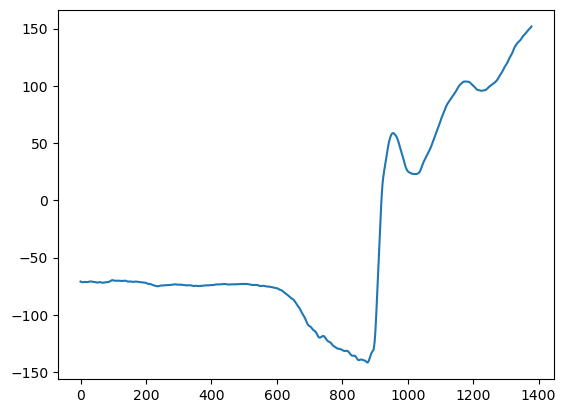

In [9]:
import matplotlib.pyplot as plt
plt.plot(kine['TORSO_ANGLE_Z'])